In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

In [34]:
# Sample Dataset

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)  # make_classification(): Generate a random n-class classification problem.
X = X.astype(np.float32)    # [[-2.0608628   2.6613927 ], ..., [-1.2685953  -1.6794535 ]]
Y = Y.astype(np.int32)      # [1 0 1 0, ..., 1 1 0 0]

# Split into train and test dataset
train_x, test_x = np.split(X, [n*8//10])    # train_x: [[ 0.94825596 -0.3122081 ], ..., [ 0.92149407  1.1544586 ]]
                                            # test_x: [[-0.00848508 -1.053148  ], ..., [ 1.1846237   0.8679223 ]]   (smaller)
train_labels, test_labels = np.split(Y, [n*8//10])  # train_labels: [0 0 1, ..., 1 0 1]
                                                    # test_labels: [0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0]   (smaller)


In [35]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')    # The text is formatted using LaTeX-style mathematical notation enclosed in dollar signs. 
                                                # x_i[0] indicates the first component of the variable x_i,
                                                # and (feature 1) is a description provided to indicate the meaning of the first component.
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)    # s: size of the markers   alpha: transparency (opacity) of the markers
    fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_3424\4057281151.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


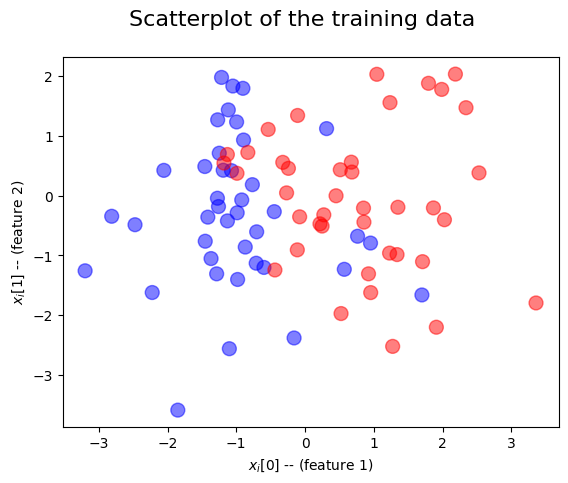

In [36]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)
plt.show()

In [37]:
print(train_x[:5])
print(train_labels[:5])

[[ 1.3382818  -0.98613256]
 [ 0.5128146   0.43299454]
 [-0.4473693  -0.2680512 ]
 [-0.9865851  -0.28692   ]
 [-1.0693829   0.41718036]]
[1 1 0 0 0]


In [38]:
# Loss functions for regression

# helper function for plotting various loss functions
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = plt.subplots(1, len(functions), figsize=(9, 3))    # Create a figure and a set of subplots.
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    plt.show()

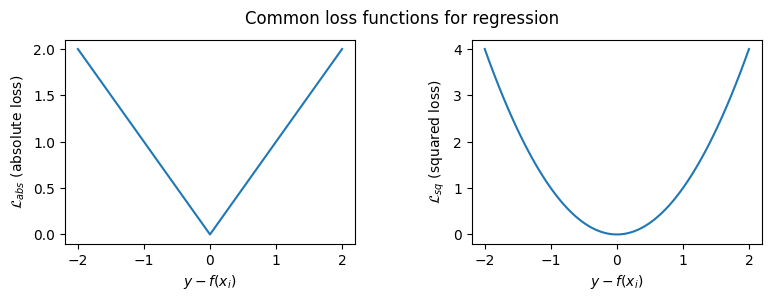

In [39]:
x = np.linspace(-2, 2, 101) # Return evenly spaced numbers over a specified interval.

plot_loss_functions(
    suptitle = 'Common loss functions for regression',
    functions = [np.abs(x), np.power(x, 2)],
    ylabels   = ['$\mathcal{L}_{abs}}$ (absolute loss)',
                 '$\mathcal{L}_{sq}$ (squared loss)'],
    xlabel    = '$y - f(x_i)$')

In [40]:
# Loss functions for classification

x = np.linspace(0,1,100)    # [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505, ..., 0.96969697 0.97979798 0.98989899 1.        ]

def zero_one(d):    # d is a scalar value representing a decision threshold.
    if d < 0.5:
        return 0
    return 1

zero_one_v = np.vectorize(zero_one)

# y represents the true label of a binary classification problem.
# Since the function logistic_loss is computing the loss when the true label is 1, y is fixed at 1 in this case.
def logistic_loss(fx):
    # assumes y == 1
    return -np.log(fx)  # fx represents the predicted probability that an input sample belongs to the positive class 


C:\Users\User\AppData\Local\Temp\ipykernel_3424\252084069.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(fx)  # fx represents the predicted probability that an input sample belongs to the positive class


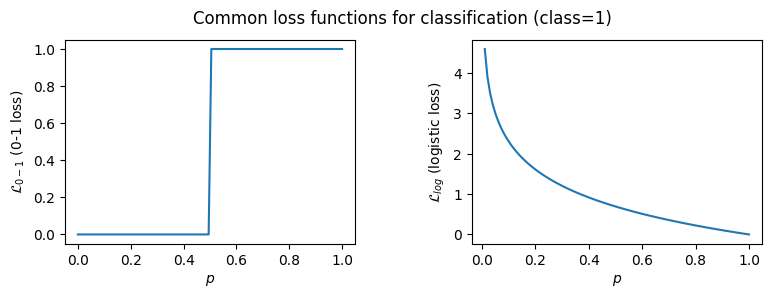

In [41]:
plot_loss_functions( 
    suptitle = 'Common loss functions for classification (class=1)',
    functions = [zero_one_v(x), logistic_loss(x)],
    ylabels    = ['$\mathcal{L}_{0-1}}$ (0-1 loss)',
                 '$\mathcal{L}_{log}$ (logistic loss)'],
    xlabel     = '$p$')

In [42]:
# Neural Network Architecture

class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))

    # produces the output of the layer 
    def forward(self, x):
        return np.dot(x, self.W.T) + self.b
    
net = Linear(2,2)
net.forward(train_x[0:5])

# Outputs are not probabilities - they can take any values. 

array([[ 1.77202116, -0.25384488],
       [ 0.28370828, -0.39610552],
       [-0.30097433,  0.30513182],
       [-0.8120485 ,  0.56079421],
       [-1.23519653,  0.3394973 ]])

In [43]:
# Softmax: Turning Outputs into Probabilities

# In order to convert outputs into probabilities, we need to normalize the values across all classes.
# This is done using softmax function

class Softmax:
    def forward(self,z):
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)   # This step is done to prevent numerical instability that can occur when dealing with large exponentials.
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z # Matrix where each row represents a probability distribution over the classes.

softmax = Softmax()
softmax.forward(net.forward(train_x[0:10])) # Getting probabilities as outputs, i.e the sum of each output vector is exactly 1.


array([[0.88348621, 0.11651379],
       [0.66369714, 0.33630286],
       [0.35294795, 0.64705205],
       [0.20216095, 0.79783905],
       [0.17154828, 0.82845172],
       [0.24279153, 0.75720847],
       [0.18915732, 0.81084268],
       [0.17282951, 0.82717049],
       [0.13897531, 0.86102469],
       [0.72746882, 0.27253118]])

In [44]:
#Cross-Entropy Loss
# Cross-entropy measures the dissimilarity between the predicted probabilities of the model and the true (target) probabilities

def cross_ent(prediction, ground_truth):
    t = 1 if ground_truth > 0.5 else 0
    return -t * np.log(prediction) - (1 - t) * np.log(1 - prediction)

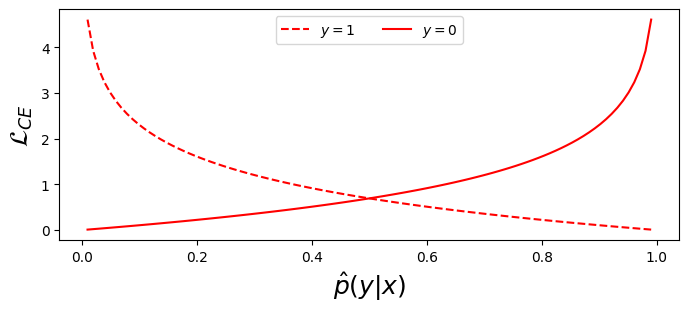

In [45]:
def plot_cross_ent():
    p = np.linspace(0.01, 0.99, 101) # estimated probability p(y|x)
    cross_ent_v = np.vectorize(cross_ent)
    f3, ax = plt.subplots(1,1, figsize=(8, 3))

    # probabilities (p) 
    # the true class labels (1 and 0) (actual or correct label of a data sample in a dataset.)
    l1, = plt.plot(p, cross_ent_v(p, 1), 'r--') # 'r--' specifies the style of the plot, where 'r' represents the color red and '--' represents a dashed line.
    l2, = plt.plot(p, cross_ent_v(p, 0), 'r-')  #  'r-' will create a plot with a solid red line.

    plt.legend([l1, l2], ['$y = 1$', '$y = 0$'], loc = 'upper center', ncol = 2)    
    plt.xlabel('$\hat{p}(y|x)$', size=18)   # A mathematical expression representing the conditional probability of y given x,
                                            # The hat symbol \hat{} indicates that it is an estimate or prediction of the probability.
    plt.ylabel('$\mathcal{L}_{CE}$', size=18)   # Sets the y-axis label of the plot to be the mathematical expression representing the cross-entropy loss.
    plt.show()

plot_cross_ent()

In [46]:
# Cross-entropy loss will be defined again as a separate layer, 
# but forward function will have two input values:  output of the previous layers of the network p
#                                                   the expected class y

"""
example:

p = array(
        [[0.8, 0.1, 0.1],
        [0.2, 0.7, 0.1],
        [0.3, 0.2, 0.5],
        [0.1, 0.3, 0.6]])

y = array([0, 2, 1, 2])

index 0, the true class label is 0, so p_of_y[0] will be p[0, 0] = 0.8.
index 1, the true class label is 2, so p_of_y[1] will be p[1, 2] = 0.1.
index 2, the true class label is 1, so p_of_y[2] will be p[2, 1] = 0.2.
index 3, the true class label is 2, so p_of_y[3] will be p[3, 2] = 0.6.

p_of_y = array([0.8, 0.1, 0.2, 0.6])

"""

class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()     # Thus after calculating cross-entropy loss for each individual component of the input vector, 
                                    # we need to average (or add) all components together

cross_ent_loss = CrossEntropyLoss()
p = softmax.forward(net.forward(train_x[0:10]))
cross_ent_loss.forward(p,train_labels[0:10])

1.429664938969559

In [47]:
# Computational Graph
# Composition of different layers can be represented as computational graph.

z = net.forward(train_x[0:10])
p = softmax.forward(z)
loss = cross_ent_loss.forward(p,train_labels[0:10])
print(loss)


1.429664938969559


In [48]:
# Implementation of Back Propagation

# Let's add backward function to each of our nodes that will compute the derivative and propagate the error during the backward pass.
# We also need to implement parameter updates according to the procedure described above

# Calculations are done not for each training sample independently, but rather for a whole minibatch.

class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)     # Array of zeros with the same shape and type as the given array.
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):    # lr: learning rate
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [49]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

In [50]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

In [51]:
# Training the Model

# Training loop, which will go through our dataset, and perform the optimization minibatch by minibatch. 
# One complete pass through the dataset is often called an epoch

lin = Linear(2,2)
softmax = Softmax()
cross_ent_loss = CrossEntropyLoss()

learning_rate = 0.1

pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Initial accuracy: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]

    # forward pass
    z = lin.forward(xb)
    p = softmax.forward(z)
    loss = cross_ent_loss.forward(p,yb)
  
    # backward pass
    dp = cross_ent_loss.backward(loss)
    dz = softmax.backward(dp)
    dx = lin.backward(dz)
    lin.update(learning_rate)
    
pred = np.argmax(lin.forward(train_x),axis=1)   # An array of indices of the maximum values along each row of the array_like.
acc = (pred==train_labels).mean()
print("Final accuracy: ",acc)

Initial accuracy:  0.725
Final accuracy:  0.825


In [52]:

# Network Class

class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)


In [53]:
net = Net()
net.add(Linear(2,2))
net.add(Softmax())
loss = CrossEntropyLoss()

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))     # The * before get_loss_acc(train_x,train_labels) unpacks the values returned by the function. 

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
 
train_epoch(net,train_x,train_labels)
        
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(test_x,test_labels)))

Initial loss=0.6212072429381601, accuracy=0.6875: 
Final loss=0.44369925927417986, accuracy=0.8: 
Test loss=0.4767711377257787, accuracy=0.85: 
